# Transfer Learning with Tensorflow: Fine-tuning

## Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-05 04:09:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-05 04:09:55 (46.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import *

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-04 20:31:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.6MB/s    in 4.7s    

2023-02-04 20:31:42 (34.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Checkout how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Training data:")
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

print("Testing data:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Training data:
Found 750 files belonging to 10 classes.
Testing data:
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 55.482143   47.070473   41.25893  ]
   [ 53.468433   43.51467    46.017857 ]
   [ 91.00734    68.86416    70.560905 ]
   ...
   [  5.          5.          7.       ]
   [  5.          5.          7.       ]
   [  5.          4.          9.       ]]

  [[ 57.647003   45.188778   30.205038 ]
   [ 62.35077    49.365112   43.71301  ]
   [ 68.27136    45.620533   40.759563 ]
   ...
   [  5.9285717   5.9285717   7.9285717]
   [  5.9285717   5.9285717   7.9285717]
   [  5.9285717   4.9285717   9.928572 ]]

  [[ 61.0676     45.57621    28.125956 ]
   [ 59.80963    45.67283    34.834503 ]
   [ 61.41167    42.764347   34.277424 ]
   ...
   [  6.          6.          8.       ]
   [  6.          6.          8.       ]
   [  6.          5.         10.       ]]

  ...

  [[ 27.491377   19.491377    6.4913764]
   [ 29.058037   21.058037    8.058036 ]
   [ 30.         22.          9.       ]
   ...
   [ 38.148907   34.148907   33.622173 ]
   [ 35.103596   31.103598   32.103596 ]
   [ 

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = keras.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base_model (aggregate all the most important information, reduce number of computation)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
            epochs=10,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230204-203152
Epoch 1/10
24/24 [==============================] - 24s 217ms/step - loss: 1.9422 - accuracy: 0.3827 - val_loss: 1.3475 - val_accuracy: 0.7253
Epoch 2/10
24/24 [==============================] - 5s 185ms/step - loss: 1.1217 - accuracy: 0.7693 - val_loss: 0.8558 - val_accuracy: 0.8289
Epoch 3/10
24/24 [==============================] - 4s 148ms/step - loss: 0.7973 - accuracy: 0.8413 - val_loss: 0.7014 - val_accuracy: 0.8454
Epoch 4/10
24/24 [==============================] - 4s 148ms/step - loss: 0.6499 - accuracy: 0.8667 - val_loss: 0.5883 - val_accuracy: 0.8569
Epoch 5/10
24/24 [==============================] - 5s 182ms/step - loss: 0.5426 - accuracy: 0.8840 - val_loss: 0.5383 - val_accuracy: 0.8668
Epoch 6/10
2

In [ ]:
# Evaluate on the full test_dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.4373 - accuracy: 0.8768


[0.4372829496860504, 0.876800000667572]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


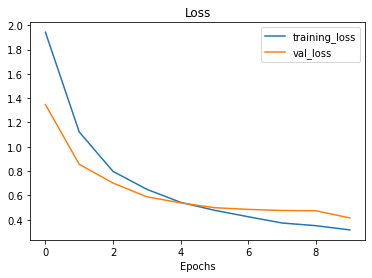

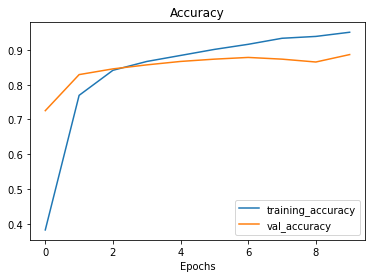

In [ ]:
# Check out our model's traning curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = layers.GlobalAveragePooling2D()(input_tensor)
print(f"Global average pooled tensor:\n {global_average_pooled_tensor}\n")
print(f"Shape: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape: (1, 3)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 10% of the training data with data augmentation

>🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-02-04 20:33:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  35.4MB/s    in 4.2s    

2023-02-04 20:33:24 (30.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [ ]:
# Create training and test dirs
train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Training data:")
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                  image_size=IMG_SIZE,
                                                                  label_mode="categorical")

print("Testing data:")
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical")

Training data:
Found 70 files belonging to 10 classes.
Testing data:
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

In [ ]:
# Create data augmentation stage with horizontal flipping, rotation, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)
plt.show()

# Now let's plot our augmented random image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(target_class)
plt.axis(False)
plt.show()

NameError: ignored

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape)

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax")(x)

# Make the model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=10,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230204-203328
Epoch 1/10
3/3 [==============================] - 12s 2s/step - loss: 2.4978 - accuracy: 0.0857 - val_loss: 2.2509 - val_accuracy: 0.1809
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 2.1844 - accuracy: 0.2571 - val_loss: 2.1332 - val_accuracy: 0.2401
Epoch 3/10
3/3 [==============================] - 4s 2s/step - loss: 2.0250 - accuracy: 0.3571 - val_loss: 2.0199 - val_accuracy: 0.3273
Epoch 4/10
3/3 [==============================] - 4s 2s/step - loss: 1.8370 - accuracy: 0.5714 - val_loss: 1.9142 - val_accuracy: 0.3865
Epoch 5/10
3/3 [==============================] - 4s 2s/step - loss: 1.6639 - accuracy: 0.6429 - val_loss: 1.8230 - val_accuracy: 0.4605
Epoch 6/10
3/3 [==============================] - 4s 2s/step - loss: 1.5124 - accuracy: 0.7571 - val_loss: 1.7324 - val_accuracy: 0.5148
Epoch 7/10
3/3 [==============================] - 4s 2s/step - loss: 1.4358 - accuracy: 0.7

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.4702 - accuracy: 0.6156


[1.4702012538909912, 0.6155999898910522]

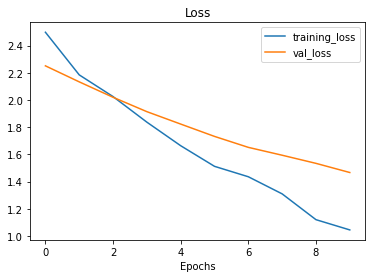

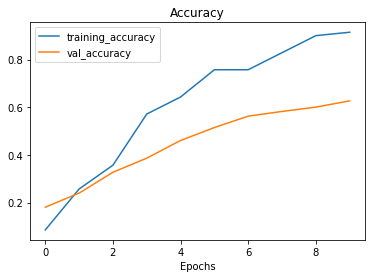

In [ ]:
# Display the loss curves
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Creat the train and the test sets

train_data_10_percent = keras.utils.image_dataset_from_directory(train_dir_10_percent,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

test_data = keras.utils.image_dataset_from_directory(test_dir,
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create the data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [ ]:
# Getting the efficient net model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the model
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=10,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230204-203434
Epoch 1/10
24/24 [==============================] - 18s 504ms/step - loss: 2.0044 - accuracy: 0.3573 - val_loss: 1.4336 - val_accuracy: 0.7072
Epoch 2/10
24/24 [==============================] - 10s 410ms/step - loss: 1.3284 - accuracy: 0.6853 - val_loss: 0.9774 - val_accuracy: 0.7878
Epoch 3/10
24/24 [==============================] - 9s 356ms/step - loss: 1.0160 - accuracy: 0.7587 - val_loss: 0.7725 - val_accuracy: 0.8289
Epoch 4/10
24/24 [==============================] - 9s 343ms/step - loss: 0.8661 - accuracy: 0.7773 - val_loss: 0.6873 - val_accuracy: 0.8355
Epoch 5/10
24/24 [==============================] - 8s 338ms/step - loss: 0.7501 - accuracy: 0.8173 - val_loss: 0.6295 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 9s 369ms/step - loss: 0.6806 - accuracy: 0.8320 - val_loss: 0.5692 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 9s 375m

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5018 - accuracy: 0.8588


[0.5018072128295898, 0.8587999939918518]

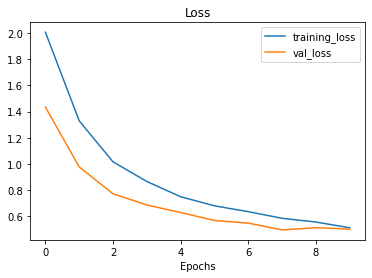

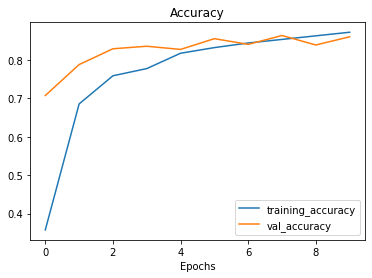

In [ ]:
# Display the loss curves
plot_loss_curves(history_2)

## Final Model

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-02-05 04:10:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.203.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   134MB/s    in 3.7s    

2023-02-05 04:10:33 (134 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Training data:")
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

print("Testing data:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Training data:
Found 7500 files belonging to 10 classes.
Testing data:
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the EfficientNet convolutional base
conv_base = keras.applications.EfficientNetB2(
    include_top=False,
    input_shape= IMG_SIZE + (3,)
)

# Creating the data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

conv_base.trainable = True
for layer in conv_base.layers[:-5]:
  layer.trainable = False

# Creating the model
inputs = keras.Input(shape= IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
final_model = keras.Model(inputs, outputs)

# Compile the model
final_model.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                    metrics=["accuracy"])
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="fine_tuning.keras",
  save_best_only=True,
  monitor="val_loss")
]


# Fit the model
history_final = final_model.fit(train_data_10_classes_full,
                                epochs=10,
                                validation_data=test_data,
                                callbacks=callbacks)

31790344/31790344 [==============================] - 0s 0us/step
Epoch 1/10
235/235 [==============================] - 59s 177ms/step - loss: 2.0961 - accuracy: 0.2919 - val_loss: 1.7676 - val_accuracy: 0.5600
Epoch 2/10
235/235 [==============================] - 39s 165ms/step - loss: 1.7391 - accuracy: 0.5519 - val_loss: 1.3861 - val_accuracy: 0.7120
Epoch 3/10
235/235 [==============================] - 40s 167ms/step - loss: 1.4799 - accuracy: 0.6463 - val_loss: 1.1270 - val_accuracy: 0.7788
Epoch 4/10
235/235 [==============================] - 40s 167ms/step - loss: 1.2957 - accuracy: 0.6967 - val_loss: 0.9506 - val_accuracy: 0.8096
Epoch 5/10
235/235 [==============================] - 39s 166ms/step - loss: 1.1615 - accuracy: 0.7276 - val_loss: 0.8262 - val_accuracy: 0.8304
Epoch 6/10
235/235 [==============================] - 39s 166ms/step - loss: 1.0520 - accuracy: 0.7444 - val_loss: 0.7328 - val_accuracy: 0.8428
Epoch 7/10
235/235 [==============================] - 40s 168ms/s

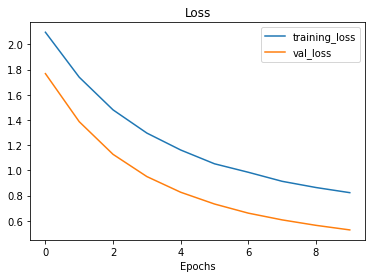

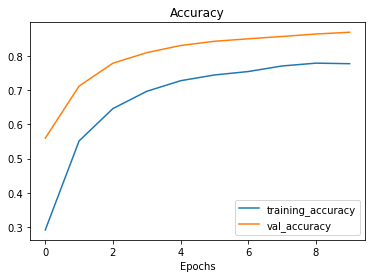

In [ ]:
plot_loss_curves(history_final)

In [ ]:
!wget https://c.ndtvimg.com/2022-06/gp4k2jro_burgers_625x300_20_June_22.jpg

--2023-02-05 04:58:13--  https://c.ndtvimg.com/2022-06/gp4k2jro_burgers_625x300_20_June_22.jpg
Resolving c.ndtvimg.com (c.ndtvimg.com)... 23.220.129.29, 2600:1408:c400:392::24e8, 2600:1408:c400:386::24e8
Connecting to c.ndtvimg.com (c.ndtvimg.com)|23.220.129.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686611 (1.6M) [image/jpeg]
Saving to: ‘gp4k2jro_burgers_625x300_20_June_22.jpg’

gp4k2jro_burgers_62 100%[===================>]   1.61M  10.6MB/s    in 0.2s    

2023-02-05 04:58:13 (10.6 MB/s) - ‘gp4k2jro_burgers_625x300_20_June_22.jpg’ saved [1686611/1686611]



In [ ]:
img = "gp4k2jro_burgers_625x300_20_June_22.jpg"

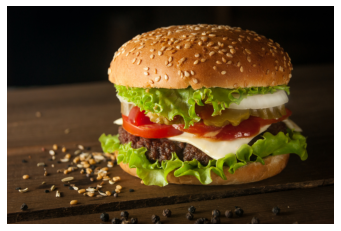

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("gp4k2jro_burgers_625x300_20_June_22.jpg")
plt.imshow(img)
plt.axis(False)
plt.show()

In [ ]:
img.shape

(3025, 4545, 3)

In [ ]:
img = tf.image.resize(img, [224, 224])
img.shape

TensorShape([224, 224, 3])

In [ ]:
pred = final_model.predict(tf.expand_dims(img, axis=0))
pred

1/1 [==============================] - 0s 26ms/step


array([[2.2616822e-04, 2.9878673e-04, 2.2915636e-04, 5.0648313e-04,
        9.9708253e-01, 3.8276389e-04, 1.6006695e-04, 2.0756955e-04,
        3.9706103e-04, 5.0940341e-04]], dtype=float32)

In [ ]:
import numpy as np
np.argmax(pred)

4

In [ ]:
class_names = train_data_10_classes_full.class_names
class_names[np.argmax(pred)]

'hamburger'